In [9]:
from pathlib import Path

import seaborn as sns

import analysis
import load_save

sns.set_theme(style="whitegrid")

In [10]:
simulation = "low_competition_under_delivery"
cases = ["ASAP", "Throttled"]

output_dir = Path("data") / simulation

In [11]:
base_distribution = load_save.load_base_distribution(output_dir)
campaigns = load_save.load_campaigns(output_dir)
events = load_save.load_events_from_multiple_cases(output_dir, cases, ["win", "no win"])

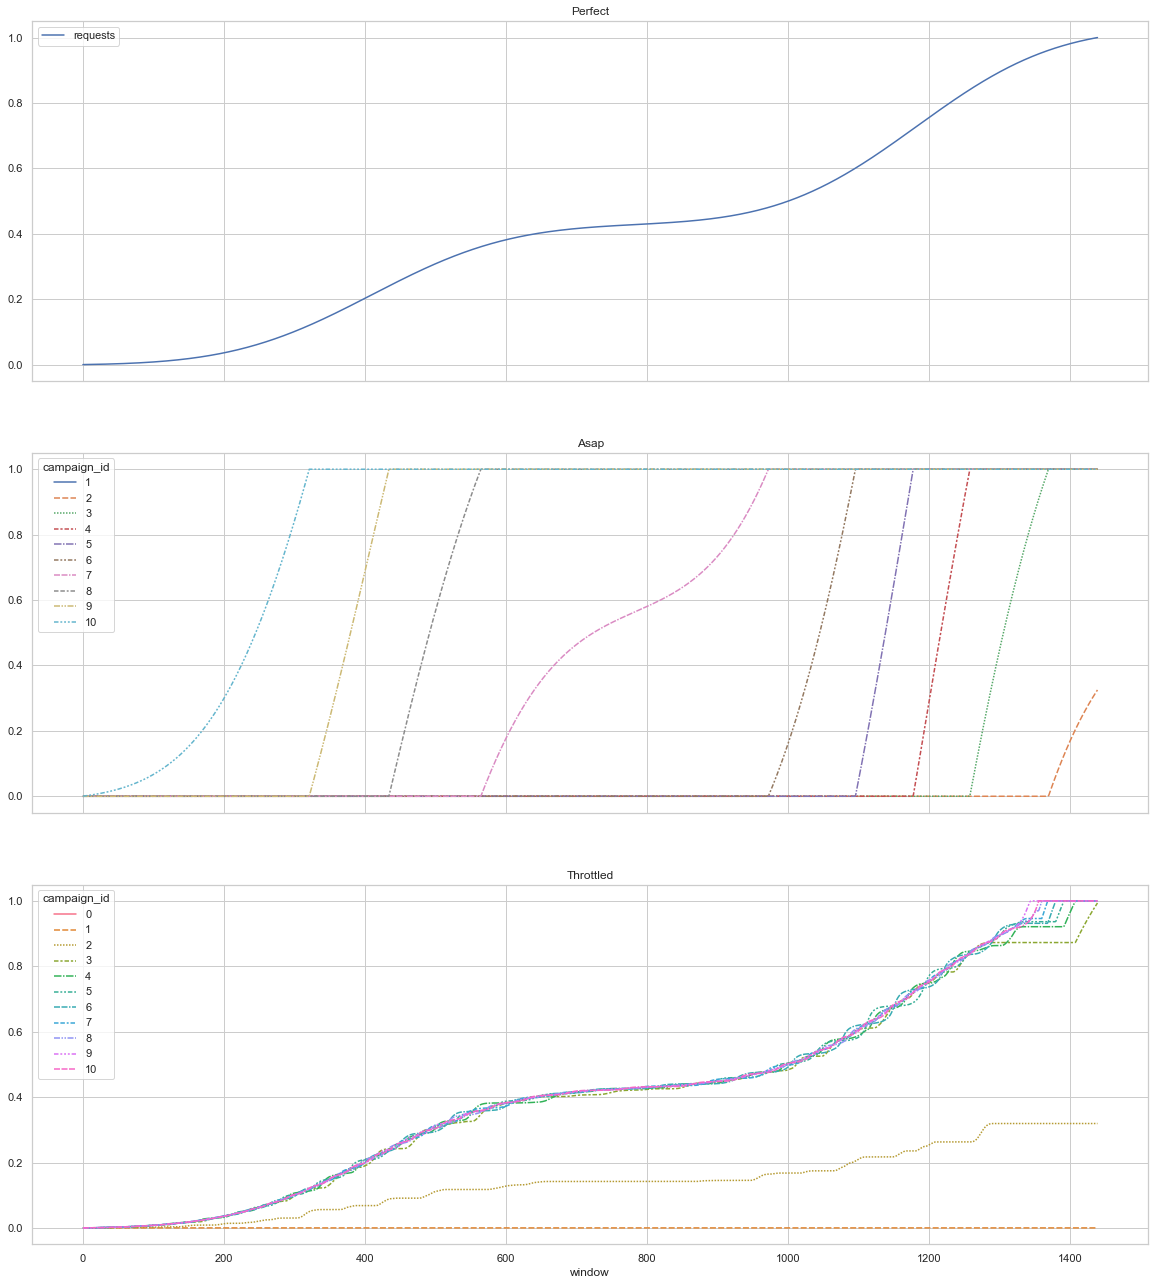

In [12]:
analysis.compare_budget_spending(campaigns, base_distribution, events)

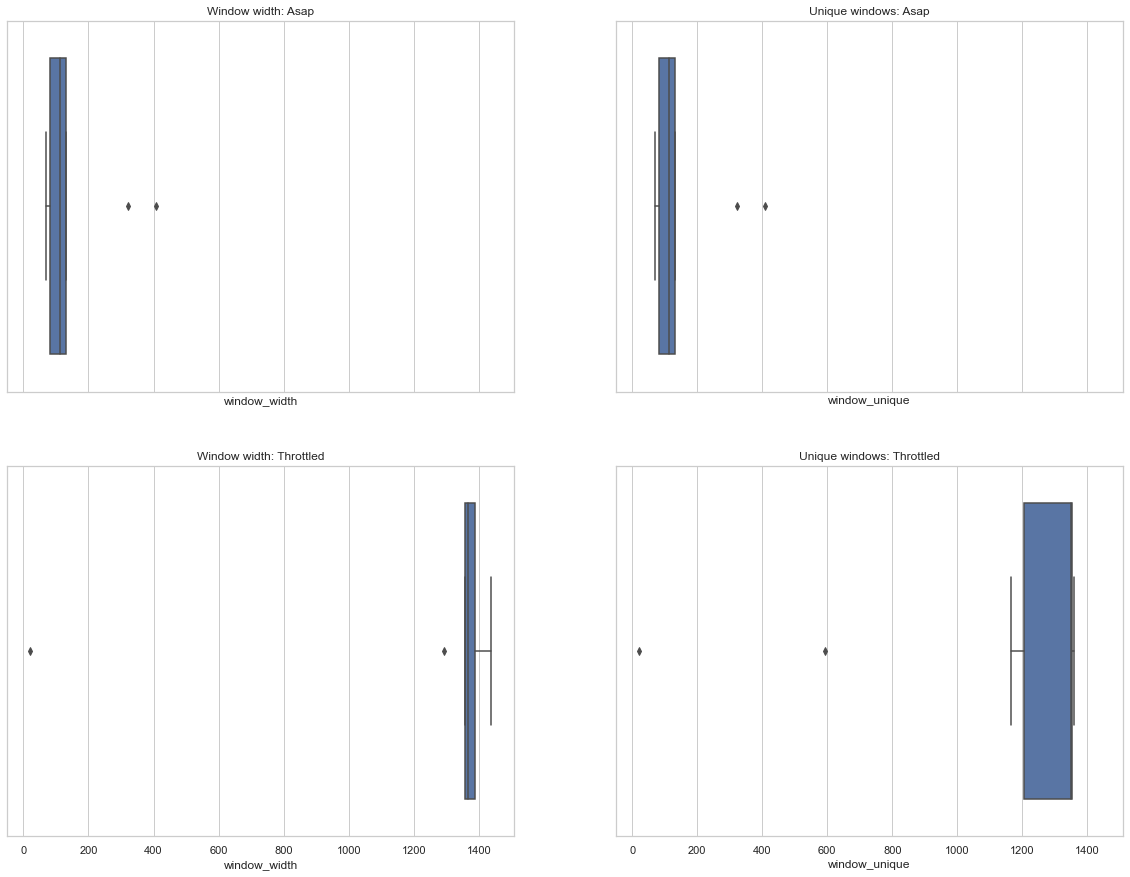

In [13]:
analysis.compare_lifespan(events)

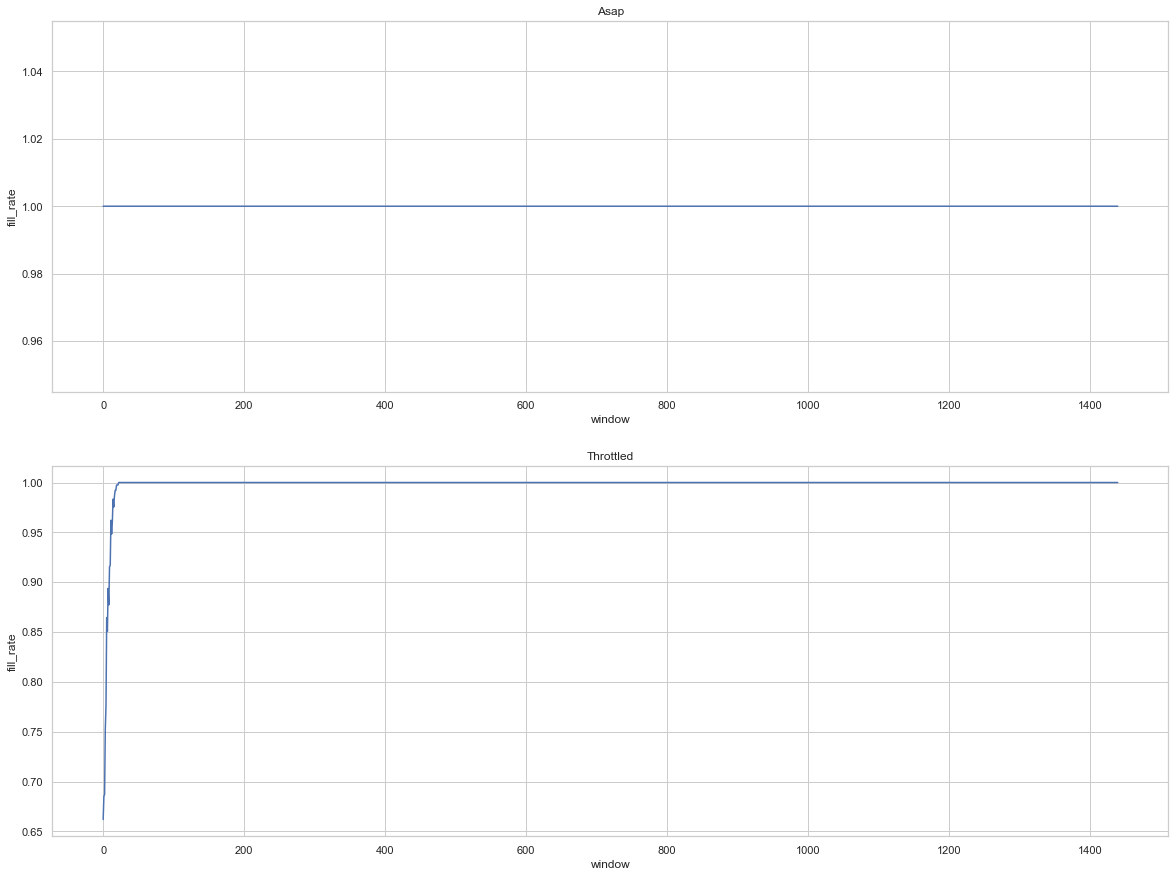

In [14]:
analysis.compare_fill_rate(events)

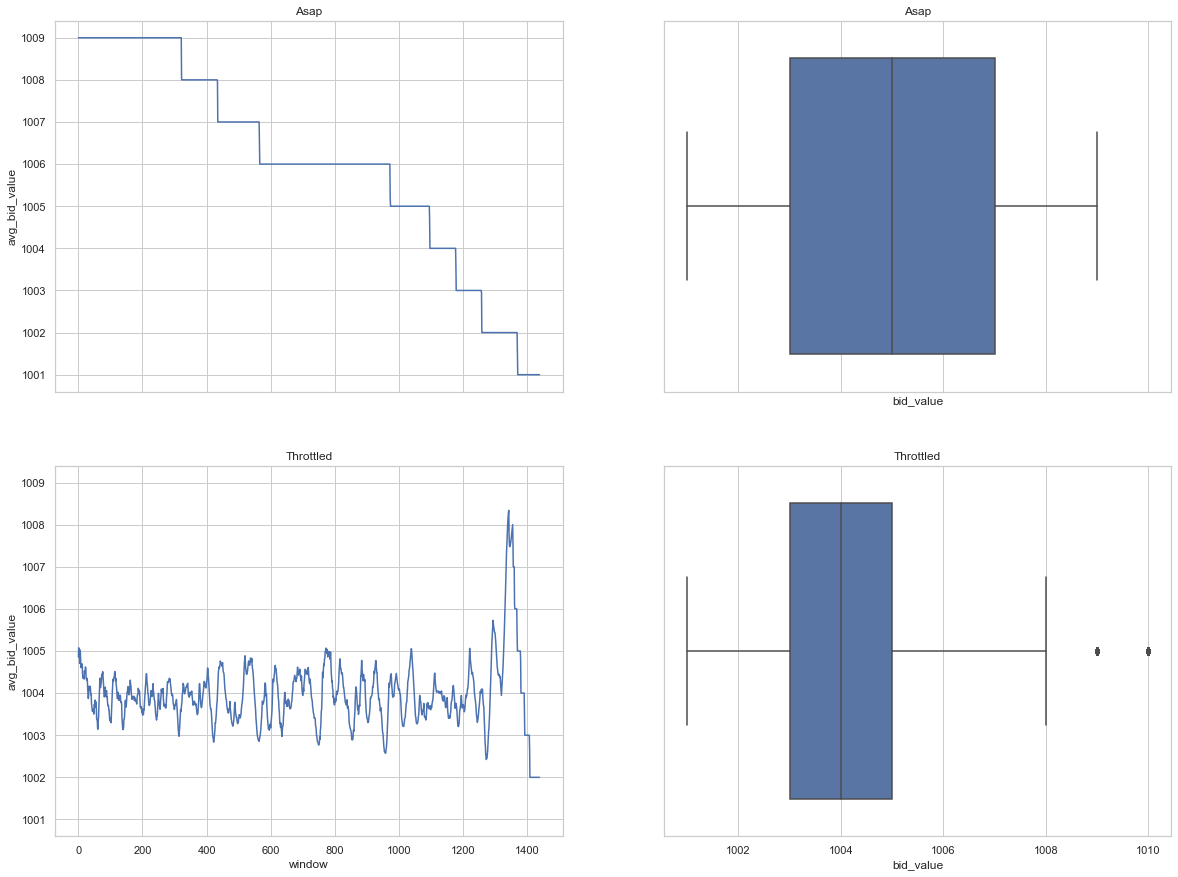

In [15]:
analysis.compare_bid_value(events)

In [16]:
analysis.summary_comparison(events)

,window_width,unique_windows,fill_rate,revenue
ASAP,0.240368,0.250644,1.000000,1.000000
Throttled,1.000000,1.000000,0.999917,0.998576
